In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [16]:
class Residual(nn.Module):
    def __init__(self, input_channels, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1, stride=strides)  # (6-3+2+2)/2=3 - 6,6,3,3
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1) # 3 -3 +2 +1 =3 4, 6,3,3
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels, kernel_size=1, stride=strides) # (6-1+2)/2 = 3 4,6,3,3
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [17]:
blk = Residual(3, 3)
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

In [18]:
blk = Residual(3, 6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

In [19]:
blk

Residual(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(3, 6, kernel_size=(1, 1), stride=(2, 2))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [20]:
# ResNet 的前两层跟之前介绍的GoogLeNet中的一样：在输出通道数为64、步幅为2的7*7卷积层后，接步幅为2的3*3的最大汇聚层。不同之处在于Resnet每个卷积层后增加了批量规范化层。

In [22]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3), # (-7+6+2)/2 高宽减半
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1)) # (-3+2+2)/2 减半

In [23]:
# GoogLeNet 在后面接了4个由Inception块组成的模块。Resnet则使用4个由残差块组成的模块，每个模块使用若干个同样输出通道数的残差块。第一个模块的通道数同输入通道数一致。由于之前已经使用了步幅为2的最大汇聚层，所以无须减小高和宽。之后的每个模块在第一个残差块里将上一个模块的通道数翻倍，并将高和宽减半。

In [24]:
def resnet_block(input_channels, num_channels, num_residuals, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

In [25]:
# 接着在ResNet加入所有残差块，这里每个模块使用2个残差块
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

In [26]:
# 最后，与GoogLeNet一样，在ResNet中加入全局平均汇聚层，以及全连接层输出

In [27]:
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1, 1)),
                    nn.Flatten(), nn.Linear(512, 10))

In [29]:
X = torch.rand(1, 1, 224, 224)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


In [30]:
# 训练模型
# 同之前一样，我们在Fashion-MNIST数据集上训练ResNet

loss 0.014, train acc 0.997, test acc 0.916
395.7 examples/sec on mps


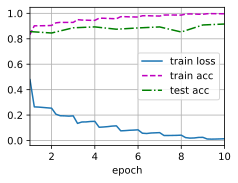

In [31]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, 'mps')